Photometry is the art of measuring the amount of light received from an astronomical object. Visualize a CCD image as a 3D surface, where the x,y plane is pixel coordinate and the z-direction is number of counts. A stellar image appears like a ‘mountain’. Our goal is to measure the volume of the mountain, i.e., the total counts from the star. To do this we must also estimate the height of the ‘plain’ that the mountain sits on.

In [1]:
# import the necessities 
import numpy as np 
import photutils
from matplotlib import pyplot as plt

from astropy.io import fits

In [2]:
# read in the data 
hdu = fits.open('/data/iraf/mr82/reduced/leomed.fits')  
image = hdu[0].data[0:2000,50:2000].astype(float)  

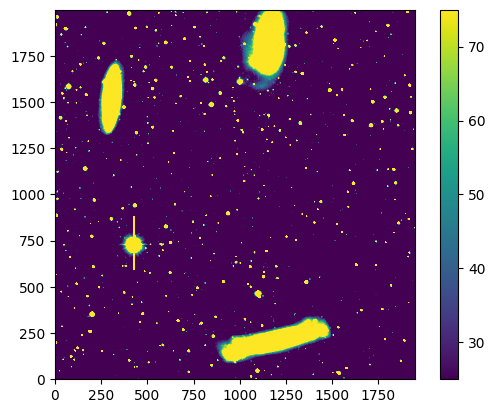

In [3]:
plt.imshow(image, origin='lower', vmin=25, vmax=75)
plt.colorbar()

In [4]:
xarray = np.vstack([np.arange(image.shape[1])]*image.shape[0])
yarray = np.tile(np.arange(image.shape[0])[:,np.newaxis], image.shape[1])

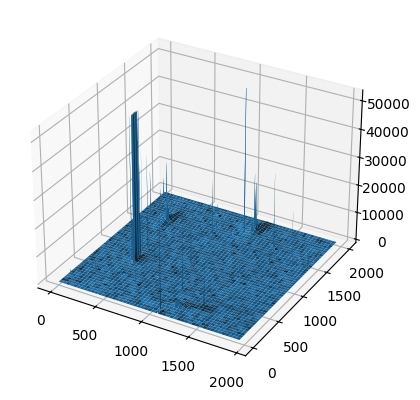

In [5]:
# Plot the surface to visualize the 'mountains' 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xarray, yarray, image)#, vmin=Z.min() * 2, cmap=cm.Blues)


Let's make a rough estimate of the image background as the median of the image and subtract that off. 

In [6]:
image -= np.nanmedian(image)  

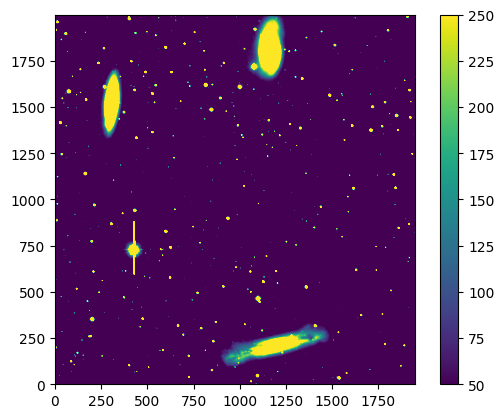

In [7]:
plt.imshow(image, origin='lower', vmin=50, vmax=250)
plt.colorbar()

Aperture photometry works by adding up all the counts in a circular aperture centered on the star (the mountain), and subtracting off the ‘average’ height of the background determined from the pixel values in an annulus around the star (the ‘plain’).

Display your combined r-band image of leo. Let's look at a moderately bright star.

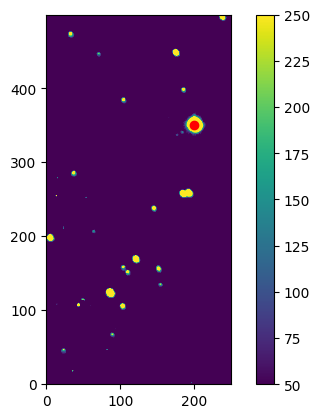

In [8]:
xstar = 200
ystar = 350 

plt.imshow(image[0:500,0:250], origin='lower', vmin=50, vmax=250)
plt.plot([xstar], [ystar], 'o', color='red')
plt.colorbar()

We'll find the centroid in order to get the true center coordinates of the star. 

In [9]:
from photutils.centroids import centroid_quadratic
xycen = centroid_quadratic(image, xpeak=xstar, ypeak=ystar)
print(xycen)  

[200.18633018 351.07973807]


In [10]:
from photutils.profiles import RadialProfile
edge_radii = np.arange(25)
rp = RadialProfile(image, xycen, edge_radii, mask=None)


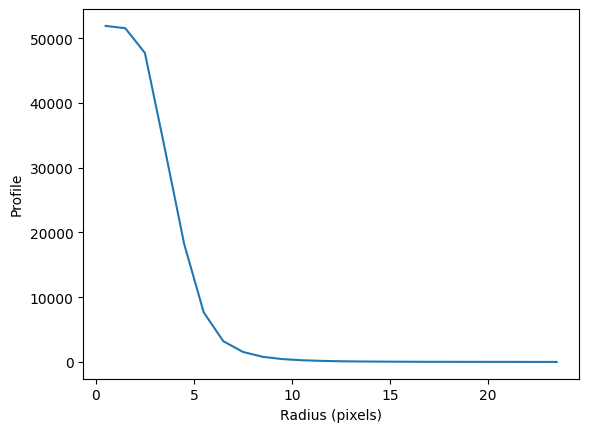

In [11]:
rp.plot(label='Radial Profile')

Now we have a graph that shows the radial profile of the star’s brightness. Now let's do the photometry. 

In [12]:
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus

positions = xycen
apertures = CircularAperture(positions, r=4.0)  
annuli = CircularAnnulus(positions, r_in=6, r_out=10)
phot_table = aperture_photometry(image, apertures)  

for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table) 

 id  xcenter   ycenter  aperture_sum
       pix       pix                
--- --------- --------- ------------
  1 200.18633 351.07974    2128564.5


(<matplotlib.patches.PathPatch at 0x1482e1640>,)

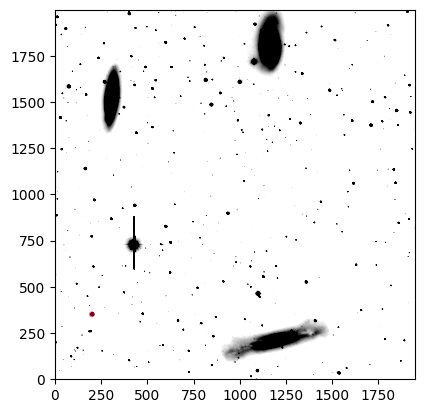

In [13]:
plt.imshow(image, cmap='gray_r', origin='lower', vmin=50, vmax=250)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annuli.plot(color='red', lw=1.5, alpha=0.5) 

(<matplotlib.patches.PathPatch at 0x1484021e0>,)

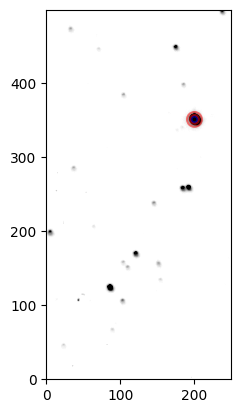

In [21]:
plt.imshow(image[:500,:250], cmap='gray_r', origin='lower', vmin=25, vmax=1250)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annuli.plot(color='red', lw=1.5, alpha=0.5) 

This is just counts. We can convert this to an (instrumental) magnitude to make a relative comparison between stars in the image. To get a real magnitude, we need to observe a standard star. 

In [22]:
from photutils.aperture import ApertureStats

aperstats = ApertureStats(image, annuli)
bkg_med = aperstats.median

print(bkg_med) 

775.8992718458176


In [23]:
total_bkg = bkg_med * apertures.area

In [24]:
total_bkg

39000.95123770384

In [25]:
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

In [26]:
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output

print(phot_table)

 id  xcenter   ycenter  aperture_sum total_bkg aperture_sum_bkgsub
       pix       pix                                              
--- --------- --------- ------------ --------- -------------------
  1 200.18633 351.07974    2128564.5 39000.951           2089563.5
